In [2]:
import numpy as np
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Train Model

### Dataloader

In [3]:
class SmokingDataset(Dataset):
    def __init__(self, dir):
        self.dir = dir
    
    def __len__(self):
        return len(os.listdir(self.dir))
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            stop, start, step = key.indices(len(self))

            length = len(range(stop, start, step))
            X = torch.zeros([length, 300])
            y = torch.zeros([length, 1])

            for j,i in enumerate(range(stop, start, step)):
                xi, yi = self[i]
                X[j] = xi
                y[j] = yi

            return (X, y)

        elif isinstance(key, int):
            X, y = torch.load(os.path.join(self.dir, f'{key}.pt'))
            return (X.flatten(), y)

In [4]:
train_dataset = SmokingDataset('pipeline/4_all/train/')
test_dataset = SmokingDataset('pipeline/4_all/test/')

train_length = len(train_dataset)
test_length = len(test_dataset)

In [5]:
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [6]:
# Define Model
n_hl = 50

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(300, n_hl),
            nn.ReLU(),
            nn.Linear(n_hl, 1)
        )
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits  

model = MLP().to(device)
    
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Define training parameters and preapre dataloaders from saved datasets

epochs = 20
batch_size = 64

losses = []
test_losses = []

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=907)    # batches for memory

n_train_batches = len(train_dataloader)
n_test_batches = len(test_dataloader)

In [8]:
# Train
for epoch in range(1):

    print(f'Epoch {epoch} - Training')
    model.train()
    for X_train, y_train in tqdm(train_dataloader):

        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Forward Pass
        logits = model(X_train)
        loss = criterion(logits, y_train)

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    print(f'Epoch {epoch} - loss: {sum(losses[-n_train_batches:])/n_train_batches}')


    ## Test
    print(f'Epoch {epoch} - Testing')
    model.eval()

    preds = []
    n_correct = 0

    for X_test, y_test in tqdm(test_dataloader):
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        logits = model(X_test)
        pred = torch.round(nn.Sigmoid()(logits))

        n_correct += sum(y_test == pred)
        preds += pred.flatten().tolist()
        loss = criterion(logits, y_test)
        test_losses.append(loss.item())


    accuracy = (n_correct / test_length).item()
    print(f'\tTest Accuracy: {100*accuracy:.4}%')
    print(f'\tTest Loss: {sum(test_losses[-n_test_batches:])/n_test_batches}')

Epoch 0 - Training


100%|██████████| 13393/13393 [01:29<00:00, 150.09it/s]


Epoch 0 - loss: 0.1098944293853486
Epoch 0 - Testing


100%|██████████| 405/405 [00:36<00:00, 11.15it/s]

	Test Accuracy: 96.93%
	Test Loss: 0.09984284197842633


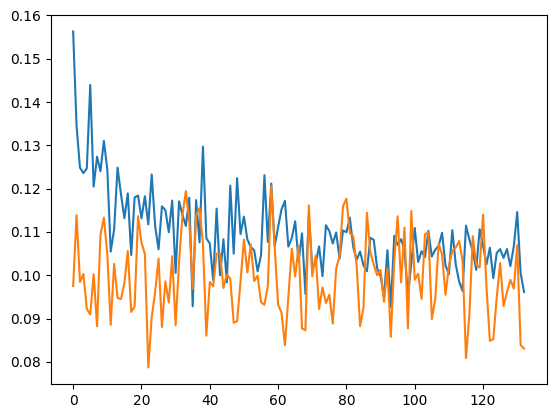

In [29]:
# Plot loss curve at specified resolution
res = 100

factor = round(len(losses) / len(test_losses))
test_losses_toplot = np.pad(np.pad(np.array(test_losses).reshape(-1, 1), ((0,0), (0,factor-1)), mode='edge').flatten(), (0, len(losses) - len(test_losses)*factor), mode='edge')

plt.plot(torch.tensor(losses)[:len(losses)-len(losses)%res].view(-1,res).mean(1))
plt.plot(torch.tensor(test_losses_toplot)[:len(test_losses_toplot)-len(test_losses_toplot)%res].view(-1,res).mean(1))
plt.savefig('loss.jpg')

In [9]:
# Test on test dataset
model.eval()

preds = []
n_correct = 0
loss = 0
i =0
for X_test, y_test in tqdm(test_dataloader):
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    logits = model(X_test)
    pred = torch.round(nn.Sigmoid()(logits))

    n_correct += sum(y_test == pred)
    preds += pred.flatten().tolist()
    loss += criterion(logits, y_test).item()
    i+=1

y_pred = np.array(preds).reshape(-1,1)
accuracy = (n_correct / test_length).item()
loss = loss / len(test_dataloader)
print(f'Accuracy: {100*accuracy:.4}%')
print(f'Loss: {loss:.5}')

Accuracy: 96.93%
Loss: 0.099843


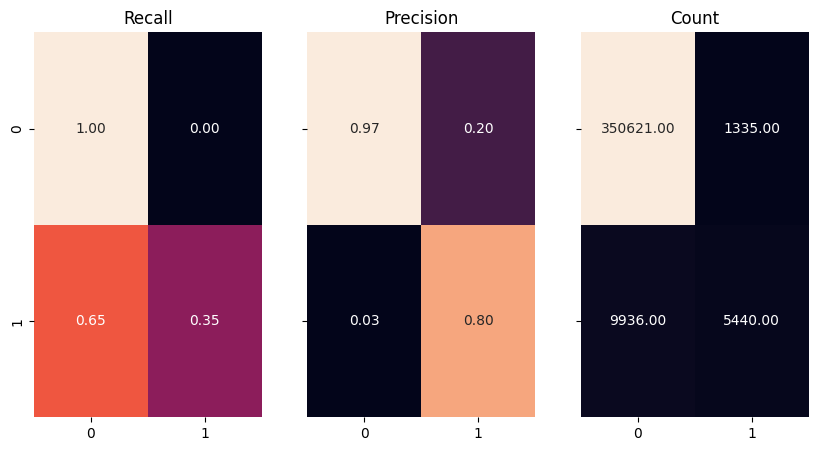

In [10]:
# Heatmap

y_true = test_dataset[:][1]

fig,axes = plt.subplots(1,3,sharey=True,figsize=(10,5))
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='true'),annot=True,ax=axes[0],cbar=False,fmt='.2f')
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred,normalize='pred'),annot=True,ax=axes[1],cbar=False,fmt='.2f')
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred),annot=True,ax=axes[2],cbar=False,fmt='.2f')
axes[0].set_title('Recall')
axes[1].set_title('Precision')
axes[2].set_title('Count')
plt.savefig(f'cm.jpg',dpi=200,bbox_inches='tight')

In [ ]:
# Save model

os.system('mkdir model')
torch.save(model.state_dict(), 'model/model.pt')